In [1]:
!pip install pymongo

In [56]:
# Imports
import bson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

## Les fichiers bson

In [3]:
# Open and read the BSON files
with open("./trictrac/details.bson", "rb") as f:
    details = bson.decode_all(f.read())


with open("./trictrac/infos_scrapping.bson", "rb") as f:
    infos = bson.decode_all(f.read())

with open("./trictrac/jeux.bson", "rb") as f:
    jeux = bson.decode_all(f.read())


with open("./trictrac/avis.bson", "rb") as f:
    avis = bson.decode_all(f.read())


## Visualisation d'un elements de chaque table

In [4]:
i=0
print(f"L'element {i} de la table des avis:\n",avis[i])
print(f"\nL'element {i} de la table des jeux:\n",jeux[i])
print(f"\nL'element {i} de la infos_scrapping des avis:\n",infos[i])
print(f"\nL'element {i} de la details des avis:\n",details[i])

L'element 0 de la table des avis:
 {'_id': ObjectId('63c6726ea81f3e3016af9a56'), 'author': 'Monsieur Guillaume', 'date_published': '2021-01-27 11:06:44', 'title_review': 'Voyages sur les ailes des papillons', 'note': 8, 'review_href': 'https://www.trictrac.net/avis/vraiment-bon-12514', 'title': 'Mariposas', 'url': 'https://www.trictrac.net/jeu-de-societe/mariposas/avis?limit=10000', 'treated': True, 'comment': "Lorsque le jeu est jeu, bon, réflexif, joli pour qui est sensible à ce style d'illustration... Lorsque l'on a envie d'y rejouer encore pour essayer autrement, et revivre cette histoire de papillons et de voyages... Et lorsqu'en plus, au détour des règles, on s'intéresse également au propos et à la sensibilisation, légère comme les ailes du dit-papillons et pourtant aussi bien amené, alors effectivement, il y a là un très bon jeu, ludiquement parlant (et il est possible de s'arrêter là) mais également très bon pour l'ouverture des yeux des joueuses et joueurs au monde qui nous en

In [5]:
len_details=len(details)
len_jeux=len(jeux)
len_infos=len(infos)
len_avis=len(avis)
print(f"Longeur de chaque table de données avis: {len_avis}, jeux: {len_jeux}, infos: {len_infos}, details : {len_details}")

no_cat = 0
for d in details:
    if d["categories"]=="":
        no_cat+=1

print(f"Nombre de jeux sans categorie: {no_cat}, poucentage de jeux non catégorisé: {((no_cat/len(details))*100):.2f}%")


Longeur de chaque table de données avis: 246524, jeux: 20235, infos: 532, details : 20234
Nombre de jeux sans categorie: 3019, poucentage de jeux non catégorisé: 14.92%


## Crée des panda dataframes

In [6]:
pdDetails = pd.DataFrame(details)
pdJeux = pd.DataFrame(jeux)
pdInfos = pd.DataFrame(infos)
pdAvis = pd.DataFrame(avis)

print("Details:\n", pdDetails.describe())
print("\nAvis:\n", pdAvis.describe())
print("\nInfos:\n", pdInfos.describe())
print("\nJeux:\n", pdJeux.describe())

Details:
                Note  Note rectifiée   Note Finkel  Nombre d'avis  \
count  20234.000000    20234.000000  20234.000000   20234.000000   
mean       4.852528        4.591857      4.897049      15.583671   
std        3.666644        3.684093      4.157989      57.265863   
min        0.000000        0.000000     -0.050000       0.000000   
25%        0.000000        0.000000      0.000000       0.000000   
50%        6.270000        6.000000      6.010000       2.000000   
75%        8.000000        7.940000      8.090000       9.000000   
max       10.000000       10.000000     41.720000    1452.000000   

       Nombre d'avis rectifiés  
count             20234.000000  
mean                 11.663438  
std                  41.129909  
min                   0.000000  
25%                   0.000000  
50%                   1.000000  
75%                   7.000000  
max                 907.000000  

Avis:
                note
count  246524.00000
mean        7.59307
std         

In [7]:
pdDetails.tail()

,_id,categories,casting,gameplay,description,full_title,titre,url,Note,Note rectifiée,Note Finkel,Nombre d'avis,Nombre d'avis rectifiés
20229,63c7effdca188a9a85b03014,Jeux de guerre,Par Richard BergIllustré par Craig GrandoÉdité...,jusqu'à 2|14 à 99 |180,\n Golden Horde est une s...,Golden Horde (2006),Golden Horde,https://www.trictrac.net/jeu-de-societe/golden...,0.00,0.00,0.00,0.0,0.0
20230,63c7effeca188a9a85b0302c,Jeux de guerre,Par John PradosIllustré par Craig GrandoÉdité ...,jusqu'à 2|14 à 99 |180,\n Toppling the Reich est...,Toppling The Reich (2006),Toppling The Reich,https://www.trictrac.net/jeu-de-societe/toppli...,0.00,0.00,0.00,0.0,0.0
20231,63c7effeca188a9a85b03046,Jeux de guerre,Par Mark StilleIllustré par Craig GrandoÉdité ...,jusqu'à 2|14 à 99 |240,\n Imperial Sunset est le...,Imperial Sunset (2006),Imperial Sunset,https://www.trictrac.net/jeu-de-societe/imperi...,0.00,0.00,0.00,0.0,0.0
20232,63c7efffca188a9a85b0306b,Jeux de cartes,Par Reiner KniziaIllustré par Michael SchoberÉ...,2 à 6|4 ans et +|15,\n Que s'est-il passé dan...,La Grande Pagaille (2006),La Grande Pagaille,https://www.trictrac.net/jeu-de-societe/la-gra...,8.00,8.00,8.09,3.0,3.0
20233,63c7f052ca188a9a85b03354,"Gestion|Hasard (Dé, Cartes, ...)|Pirate",Par Gilles BecqIllustré par Kevin WandrolÉdité...,2 à 4|10 ans et +|30,\n Soyez le premier à réu...,Dice Seadog (2013),Dice Seadog,https://www.trictrac.net/jeu-de-societe/dice-s...,5.77,5.55,5.56,3.0,2.0


In [8]:
pdJeux.tail()

,_id,title,href,treated,avis
20230,63c68a2f22080b33e5b59ce6,Quelques Arpents de Neige,https://www.trictrac.net/jeu-de-societe/quelqu...,True,False
20231,63c68a2f22080b33e5b59ce7,Toppling The Reich,https://www.trictrac.net/jeu-de-societe/toppli...,True,False
20232,63c68a2f22080b33e5b59ce8,La Vallée de la Mort,https://www.trictrac.net/jeu-de-societe/la-val...,True,False
20233,63c68a2f22080b33e5b59ce9,La Grande Pagaille,https://www.trictrac.net/jeu-de-societe/la-gra...,True,False
20234,63c68a2f22080b33e5b59cea,Imperial Sunset,https://www.trictrac.net/jeu-de-societe/imperi...,True,False


In [9]:
pdInfos.head()

,_id,url,num_page,count
0,63c17a0030ad62ea332eaea0,https://www.trictrac.net/jeu-de-societe/?order...,1,32
1,63c17a0130ad62ea332eaef0,https://www.trictrac.net/jeu-de-societe/?order...,0,32
2,63c17a0130ad62ea332eaf01,https://www.trictrac.net/jeu-de-societe/?order...,7,31
3,63c17a0130ad62ea332eaf02,https://www.trictrac.net/jeu-de-societe/?order...,6,32
4,63c17a0130ad62ea332eaf23,https://www.trictrac.net/jeu-de-societe/?order...,4,32


In [10]:
pdAvis.head(10)

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment
0,63c6726ea81f3e3016af9a56,Monsieur Guillaume,2021-01-27 11:06:44,Voyages sur les ailes des papillons,8.0,https://www.trictrac.net/avis/vraiment-bon-12514,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,63c6726ea81f3e3016af9a57,morlockbob,2020-10-18 10:04:21,le festival de Michoacan,7.0,https://www.trictrac.net/avis/le-festival-de-m...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Comment continuer après un mega hit ? Simpleme...
2,63c6726ea81f3e3016af9a58,SwatSh,2021-02-01 08:35:08,Vivez la migration des monarques,7.0,https://www.trictrac.net/avis/vivez-la-migrati...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,63c6726ea81f3e3016af9a59,Timi JeuxATheme,2020-11-19 17:04:57,Bon,8.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN
4,63c6726ea81f3e3016af9a5a,prunelles,2021-05-24 12:43:18,Envolez-moi,9.0,https://www.trictrac.net/avis/envolez-moi,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Très joli bijou que ce jeu-là ! Le matériel, l..."
5,63c6726ea81f3e3016af9a5b,BSI40,2022-09-23 17:16:27,Manque un peu de souffle,7.0,https://www.trictrac.net/avis/manque-un-peu-de...,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,Mariposas est plutôt beau avec un grand platea...
6,63c6726ea81f3e3016af9a5c,kakawette,2020-09-10 23:16:35,"Papillon de lumière, sous les projecteurs",7.0,https://www.trictrac.net/avis/bon-13703,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,"Simple d'accès, mais tout de même un peu tacti..."
7,63c6726ea81f3e3016af9a5d,PawnPawn,2021-05-10 08:29:40,Pas mauvais,6.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN
8,63c6726ea81f3e3016af9a5e,M.PinK,2021-08-29 10:37:54,Bon,7.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN
9,63c6726ea81f3e3016af9a5f,micmac85,2022-01-04 14:07:17,Bon,8.0,None,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,True,NaN


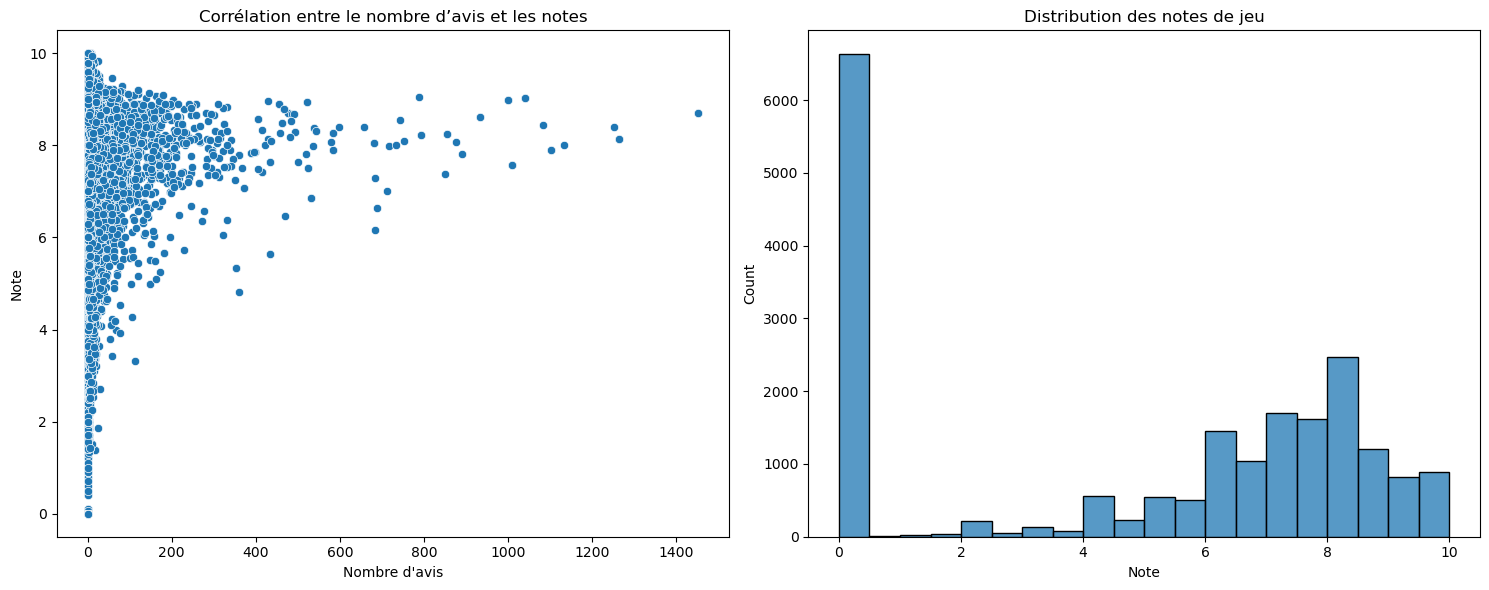

Coefficient de corrélation entre le nombre d’avis et les notes: 0.214


In [11]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pdDetails, x='Nombre d\'avis', y='Note')
plt.title('Corrélation entre le nombre d’avis et les notes')
plt.xlabel("Nombre d'avis")
plt.ylabel('Note')

plt.subplot(1, 2, 2)
sns.histplot(data=pdDetails, x='Note', bins=20)
plt.title('Distribution des notes de jeu')
plt.xlabel('Note')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

correlation = pdDetails['Nombre d\'avis'].corr(pdDetails['Note'])
print(f"Coefficient de corrélation entre le nombre d’avis et les notes: {correlation:.3f}")
# Il y a une tendence ou des jeux avec plus de commentaires pour avoir des notes plus élevées
# Cependant, la corrélation est forte

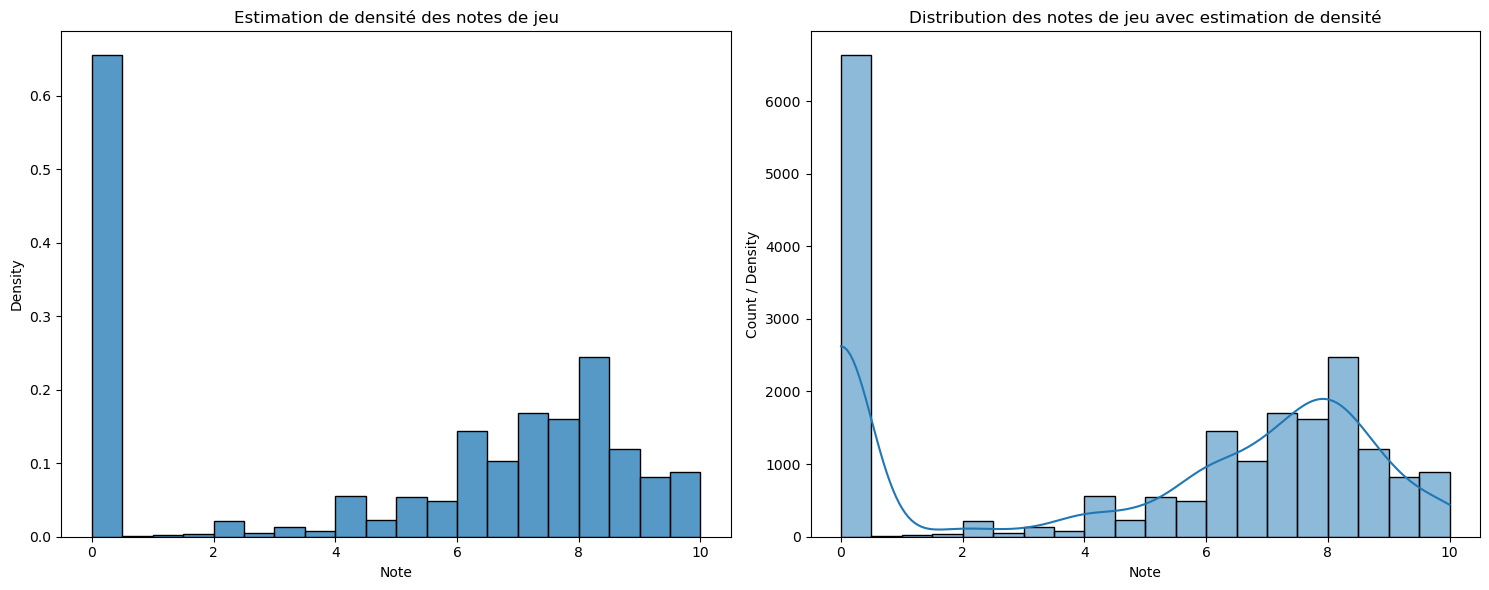

In [12]:
plt.figure(figsize=(15, 6))

# Histogramme pour l'estimation de densité (normalisé)
plt.subplot(1, 2, 1)
sns.histplot(data=pdDetails, x='Note', bins=20, stat="density")
plt.title('Estimation de densité des notes de jeu')
plt.xlabel('Note')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.histplot(data=pdDetails, x='Note', bins=20, kde=True)
plt.title('Distribution des notes de jeu avec estimation de densité')
plt.xlabel('Note')
plt.ylabel('Count / Density')

plt.tight_layout()
plt.show()


In [13]:
mean_note = pdDetails['Note'].mean()
median_note = pdDetails['Note'].median()
print(f"Moyenne des notes : {mean_note:.2f}")
print(f"Médiane des notes : {median_note:.2f}")
skewness = pdDetails['Note'].skew()
print(f"Skewness (asymétrie) : {skewness:.2f}") #skewness < 0 : les notes sont etirees vers la gauche (plus de notes élevées).

Moyenne des notes : 4.85
Médiane des notes : 6.27
Skewness (asymétrie) : -0.36


In [14]:
# Method 1: Using pdDetails to check games with 0 reviews
games_no_reviews_1 = len(pdDetails[pdDetails["Nombre d'avis"] == 0.0])

# Method 2: Using pdJeux to check games with no reviews
games_no_reviews_2 = len(pdJeux[pdJeux["avis"] == False])

print(f"Nombre de jeux avec 0 avis (utilisant pdDetails): {games_no_reviews_1}")
print(f"Nombre de jeux sans avis (en utilisant pdJeux): {games_no_reviews_2}")

# Calculate percentage
total_games = len(pdDetails)
percentage_no_reviews = (games_no_reviews_1 / total_games) * 100

print(f"\nPourcentage de jeux sans avis : {percentage_no_reviews:.2f}%")


#Probleme de consistence entre les 2 datas (ASK LE MONSIEUR)


Nombre de jeux avec 0 avis (utilisant pdDetails): 6616
Nombre de jeux sans avis (en utilisant pdJeux): 18

Pourcentage de jeux sans avis : 32.70%


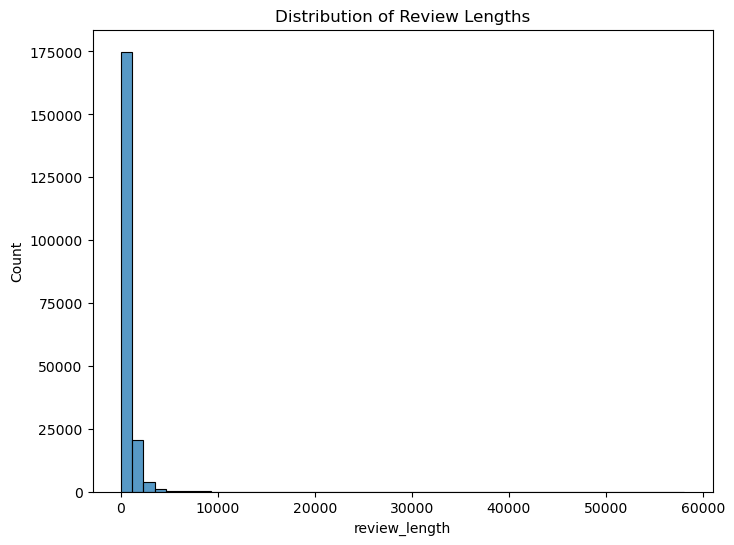

Average review length: 619 characters


In [15]:
pdAvis['review_length'] = pdAvis['comment'].str.len()

plt.figure(figsize=(8, 6))
sns.histplot(data=pdAvis, x='review_length',bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

print(f"Average review length: {pdAvis['review_length'].mean():.0f} characters")

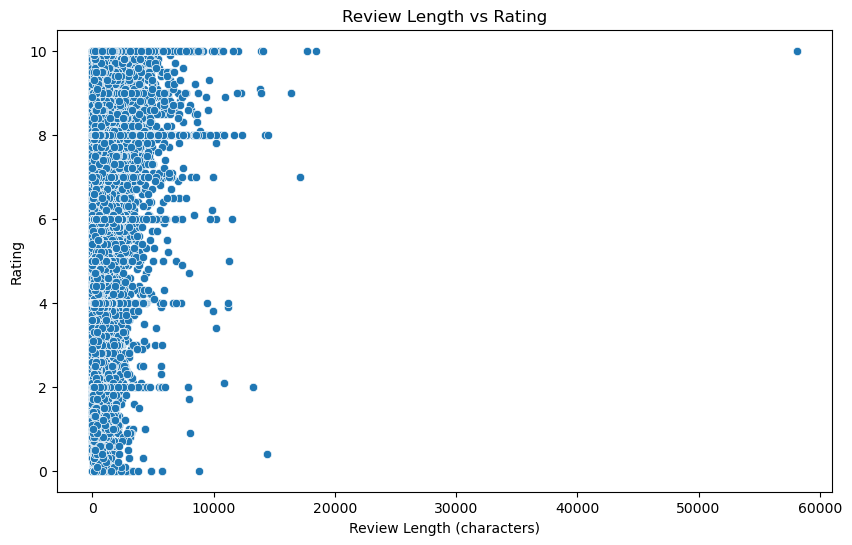

In [16]:
# Analyze if review length correlates with rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdAvis, x='review_length', y='note')
plt.title('Review Length vs Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Rating')
plt.show()

# Preprocessing

- We found 2 reviews with around 60000 words that arent interesting to keep (they are spam)

In [17]:
pdAvis[pdAvis["author"]== "The Lonesome Meeple"]

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,review_length
21474,63c67500993b727dc2a7a0d7,The Lonesome Meeple,2020-04-21 22:32:46,Histoire de Meeples #4 SOS Dino |Partie Narrat...,10.0,https://www.trictrac.net/avis/histoire-de-meep...,SOS DINO,https://www.trictrac.net/jeu-de-societe/sos-di...,True,Récit à retrouver avec photos sur mon blog His...,12044.0
22193,63c67506993b727dc2a7a3a6,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,58097.0
79884,63c6776e993b727dc2a88501,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,58097.0
84272,63c67799993b727dc2a89625,The Lonesome Meeple,2020-04-21 22:32:46,Histoire de Meeples #4 SOS Dino |Partie Narrat...,10.0,https://www.trictrac.net/avis/histoire-de-meep...,SOS DINO,https://www.trictrac.net/jeu-de-societe/sos-di...,True,Récit à retrouver avec photos sur mon blog His...,12044.0


In [18]:
pdAvis[pdAvis["review_length"]==58097.0]

,_id,author,date_published,title_review,note,review_href,title,url,treated,comment,review_length
22193,63c67506993b727dc2a7a3a6,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,58097.0
79884,63c6776e993b727dc2a88501,The Lonesome Meeple,2020-04-16 18:24:56,Histoire de Meeples #1 Sub Terra [Partie narra...,10.0,https://www.trictrac.net/avis/sub-terra-partie...,Sub Terra,https://www.trictrac.net/jeu-de-societe/sub-te...,True,Récit à retrouver sur mon blog Histoires de Me...,58097.0


In [19]:
print(f"Dimensions de pdAvis avant nettoyage : {pdAvis.shape}")

Dimensions de pdAvis avant nettoyage : (246524, 11)


In [20]:
pdAvis=pdAvis[pdAvis["review_length"] != 58097.0]
print(f"Dimensions de pdAvis après nettoyage : {pdAvis.shape}")

Dimensions de pdAvis après nettoyage : (246522, 11)


In [21]:
#enlever les doublons
print(f"Dimensions de pdAvis avant nettoyage : {pdAvis.shape}")
pdAvis.drop_duplicates(subset=['author', 'date_published', 'title_review', 'note', 'review_href', 'title', 'url', 'treated', 'comment' , 'review_length'], inplace=True)
print(f"Dimensions de pdAvis après nettoyage : {pdAvis.shape}")


Dimensions de pdAvis avant nettoyage : (246522, 11)
Dimensions de pdAvis après nettoyage : (176242, 11)


In [22]:
print(f"Dimensions de pdJeux avant nettoyage : {pdJeux.shape}")
pdJeux.drop_duplicates(subset=['title',	'href', 'treated', 'avis'], inplace=True)
print(f"Dimensions de pdJeux après nettoyage : {pdJeux.shape}")

Dimensions de pdJeux avant nettoyage : (20235, 5)
Dimensions de pdJeux après nettoyage : (16875, 5)


- We redid the statistcs about the review length to verify, all is good,the highest review is real

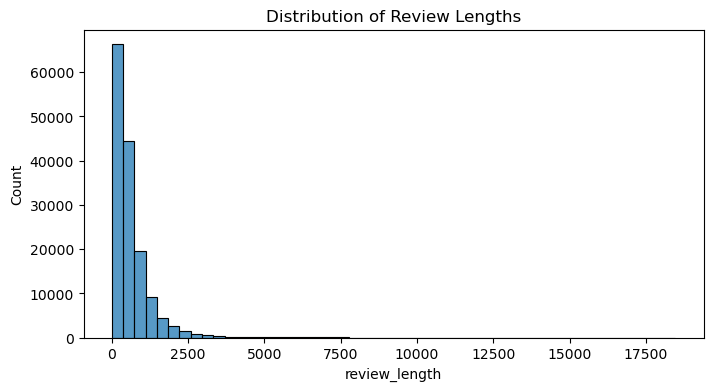

Average review length: 606 characters


In [23]:

plt.figure(figsize=(8, 4))
sns.histplot(data=pdAvis, x='review_length',bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

print(f"Average review length: {pdAvis['review_length'].mean():.0f} characters")

In [24]:
allgames = sorted(pdJeux["title"].unique())
allusers = sorted(pdAvis['author'].unique())

print(f"Nombre des jeux {len(allgames)} et nombre de users {len(allusers)}")
print(f"Dimensions de pdAvis avant nettoyage : {pdAvis.shape}")

Nombre des jeux 16366 et nombre de users 13623
Dimensions de pdAvis avant nettoyage : (176242, 11)


In [25]:
from scipy.sparse import csr_matrix

# Création d'une matrice DataFrame dense (comme avant)
ratings_matrix = pd.DataFrame(
    index=allusers,
    columns=allgames,
    dtype=float
)

# Remplissage de la matrice avec les notes
for _, row in pdAvis.iterrows():
    ratings_matrix.at[row['author'], row['title']] = row['note']

# Conversion en matrice sparse
sparse_ratings_matrix = csr_matrix(ratings_matrix.fillna(0))

print("Matrice sparse créée avec succès.")

Matrice sparse créée avec succès.


In [26]:
sparse_ratings_matrix[0]

<1x16366 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [27]:
print(f"Matrix shape: {ratings_matrix.shape}")
print(f"\nMissing values: {ratings_matrix.isnull().sum().sum()}")
print(f"Fill rate: {(1 - ratings_matrix.isnull().sum().sum()/(len(allusers)*len(allgames)))*100:.2f}%")


# Check sparsity
non_null_counts = ratings_matrix.count()
print("\nTop 10 most rated games:")
print(non_null_counts.sort_values(ascending=False).head(10))

Matrix shape: (13623, 16366)

Missing values: 222777948
Fill rate: 0.08%

Top 10 most rated games:
Shogun                   172
Non Merci                158
Boomerang                156
Les mystères de Pékin    155
Eclipse                  155
Dune                     153
Mare Nostrum             153
Poker                    151
Guillotine               151
Elysium                  151
dtype: int64


In [28]:
ratings_matrix_cleaned = ratings_matrix.dropna(axis=1, how='all') #les jeux qui n'ont aucun review
print(f"Removed {ratings_matrix.shape[1] - ratings_matrix_cleaned.shape[1]} games with no ratings")
copy= ratings_matrix_cleaned.copy()
print(f"Matrix shape: {ratings_matrix_cleaned.shape}")

Removed 5657 games with no ratings
Matrix shape: (13623, 10709)


Matrix shape: (13623, 10709)


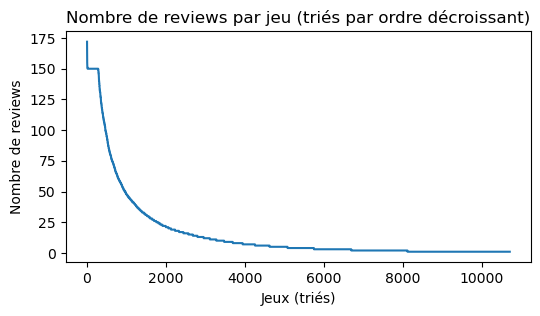

In [29]:
print(f"Matrix shape: {ratings_matrix_cleaned.shape}")
reviews_per_game = ratings_matrix_cleaned.count(axis=0)

# Tracer la courbe du nombre de reviews par jeu
plt.figure(figsize=(6, 3))
sns.lineplot(data=reviews_per_game.sort_values(ascending=False).reset_index(drop=True))
plt.title("Nombre de reviews par jeu (triés par ordre décroissant)")
plt.xlabel("Jeux (triés)")
plt.ylabel("Nombre de reviews")
plt.show()


In [30]:
review_counts = ratings_matrix_cleaned.count(axis=0)
popular_games = review_counts[review_counts >= 11].index
print(ratings_matrix_cleaned[popular_games].shape)

(13623, 3274)


explication : 
reviews_per_game : Compte le nombre de reviews pour chaque jeu et les trie dans l'ordre décroissant (le jeu avec le plus de reviews est en tête).
cumulative_reviews : Calcule la distribution cumulative des reviews. Cela montre la proportion des reviews couvertes au fur et à mesure que l'on inclut plus de jeux.
base_cutoff_index : Trouve l'indice du premier jeu où au moins 80% des reviews sont couvertes.
base_num_reviews : Proportion cumulative des reviews à ce seuil.
base_num_games : Nombre de jeux nécessaires pour couvrir 80% des reviews.

Pourcentage : 75%
Nombre de jeux : 1949, Nombre de reviews couvertes : 75.01%
Différence cumulée : -1076 jeux, -9.99% reviews
Ratio (augmentation de reviews / jeux ajoutés) : 0.00

Pourcentage : 76%
Nombre de jeux : 2030, Nombre de reviews couvertes : 76.00%
Différence cumulée : -995 jeux, -9.00% reviews
Ratio (augmentation de reviews / jeux ajoutés) : 0.00

Pourcentage : 77%
Nombre de jeux : 2117, Nombre de reviews couvertes : 77.01%
Différence cumulée : -908 jeux, -8.00% reviews
Ratio (augmentation de reviews / jeux ajoutés) : 0.00

Pourcentage : 78%
Nombre de jeux : 2209, Nombre de reviews couvertes : 78.01%
Différence cumulée : -816 jeux, -7.00% reviews
Ratio (augmentation de reviews / jeux ajoutés) : 0.00

Pourcentage : 79%
Nombre de jeux : 2306, Nombre de reviews couvertes : 79.01%
Différence cumulée : -719 jeux, -5.99% reviews
Ratio (augmentation de reviews / jeux ajoutés) : 0.00

Pourcentage : 80%
Nombre de jeux : 2408, Nombre de reviews couvertes : 80.01%
Différence cumulée : 

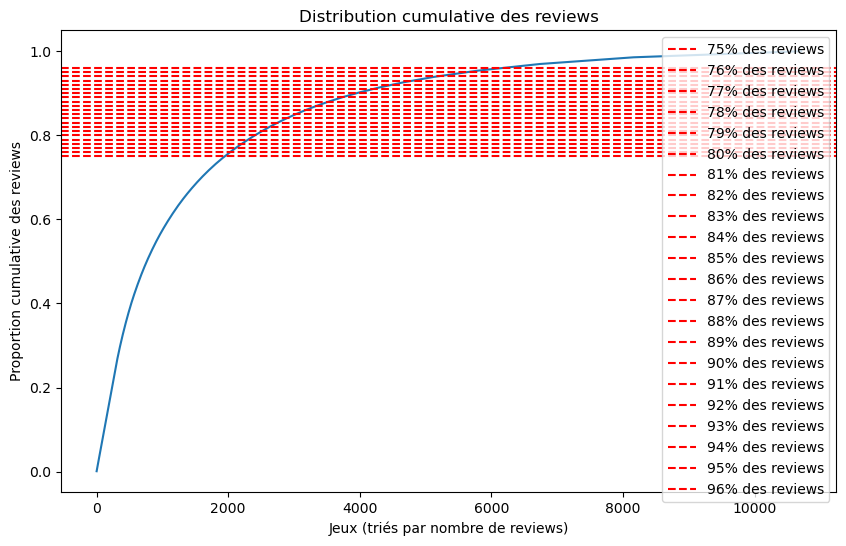

In [31]:
# Calculer le nombre de reviews par jeu, trié par ordre décroissant
reviews_per_game = ratings_matrix_cleaned.count(axis=0).sort_values(ascending=False)

# Calculer la distribution cumulative
cumulative_reviews = reviews_per_game.cumsum() / reviews_per_game.sum()

# Définir l'intervalle de pourcentages à tester
percentages = np.arange(0.75, 0.97, 0.01)  # De 0.75 à 0.96 inclus, avec un pas de 0.01

# Initialiser une figure
plt.figure(figsize=(10, 6))
sns.lineplot(data=cumulative_reviews.reset_index(drop=True))
plt.title("Distribution cumulative des reviews")
plt.xlabel("Jeux (triés par nombre de reviews)")
plt.ylabel("Proportion cumulative des reviews")

# Initialiser les variables pour stocker les résultats
optimal_percentage = None
max_reviews_per_game_ratio = 0

# Réinitialiser les indices pour un accès basé sur des entiers
cumulative_reviews_reset = cumulative_reviews.reset_index(drop=True)

# Trouver l'index numérique correspondant au seuil de 0.8
base_cutoff_index = (cumulative_reviews_reset >= 0.85).idxmax()
# Nombre de reviews à ce seuil
base_num_reviews = cumulative_reviews_reset.loc[base_cutoff_index]
# Nombre de jeux nécessaires
base_num_games = base_cutoff_index + 1

for percentage in percentages:
    # Réinitialiser les indices pour un accès basé sur des entiers
    cumulative_reviews_reset = cumulative_reviews.reset_index(drop=True)
    cutoff_index = (cumulative_reviews_reset >= percentage).idxmax()  # Trouver l'indice du seuil
    num_reviews_covered = cumulative_reviews_reset.loc[cutoff_index]

    # Nombre de jeux nécessaires
    num_games = cutoff_index + 1

    # Tracer la ligne de seuil
    plt.axhline(percentage, color='r', linestyle='--', label=f"{int(percentage * 100)}% des reviews")

    # Calculer les différences cumulatives par rapport à la baseline
    reviews_diff = (num_reviews_covered - base_num_reviews) * 100  # Convertir en %
    games_diff = num_games - base_num_games
    reviews_per_game_ratio =0 
    # Calculer le ratio d'augmentation des reviews par jeu ajouté
    if games_diff > 0:  # Éviter une division par zéro
        reviews_per_game_ratio = reviews_diff / games_diff

        # Vérifier si ce ratio est le maximum trouvé
        if reviews_per_game_ratio > max_reviews_per_game_ratio:
            optimal_percentage = percentage
            max_reviews_per_game_ratio = reviews_per_game_ratio

    # Afficher les détails
    print(f"Pourcentage : {int(percentage * 100)}%")
    print(f"Nombre de jeux : {num_games}, Nombre de reviews couvertes : {num_reviews_covered * 100:.2f}%")
    print(f"Différence cumulée : {games_diff} jeux, {reviews_diff:.2f}% reviews")
    print(f"Ratio (augmentation de reviews / jeux ajoutés) : {reviews_per_game_ratio:.2f}\n")

# Afficher le seuil optimal trouvé
print(f"Seuil optimal trouvé : {optimal_percentage * 100:.2f}%")
print(f"Max ratio reviews / jeux ajoutés : {max_reviews_per_game_ratio:.2f}")

# Ajouter la légende et afficher le graphique
plt.legend()
plt.show()


In [32]:
print(ratings_matrix_cleaned.shape)

(13623, 10709)


In [33]:
# Déterminer l'indice correspondant au seuil optimal
optimal_cutoff_index = (cumulative_reviews_reset >= optimal_percentage).idxmax()

# Sélectionner les jeux jusqu'à l'indice optimal
popular_games = cumulative_reviews.index[:optimal_cutoff_index + 1]

# Filtrer la matrice pour ne garder que les jeux populaires
ratings_matrix_cleaned = ratings_matrix_cleaned[popular_games]

# Afficher les dimensions de la matrice après filtrage
print(f"Dimensions de la matrice filtrée : {ratings_matrix_cleaned.shape}")


Dimensions de la matrice filtrée : (13623, 3177)


In [45]:
ratings_matrix_cleaned = ratings_matrix_cleaned.dropna(axis=0, how='all') # remove all users who havent reviewed any games from the remaining games
print(f"Matrix shape: {ratings_matrix_cleaned.shape}")

Matrix shape: (12632, 3177)


In [46]:
print(f"\nMissing values: {ratings_matrix_cleaned.isnull().sum().sum()}")
print(f"Fill rate: {(1 - ratings_matrix_cleaned.isnull().sum().sum()/(ratings_matrix_cleaned.shape[0]*ratings_matrix_cleaned.shape[1]))*100:.2f}%")


Missing values: 39980443
Fill rate: 0.38%


In [44]:

# Étape 1 : Remplir les NaN par 0
ratings_filled = ratings_matrix_cleaned.fillna(0)

# Étape 2 : Calculer la moyenne de chaque utilisateur
user_means = ratings_filled.mean(axis=1)

# Étape 3 : Soustraire la moyenne de chaque utilisateur de ses notes
# Broadcasting permet de soustraire la moyenne à chaque ligne
ratings_normalized = ratings_filled.sub(user_means, axis=0)

# Afficher la matrice finale
print("Matrice remplie et normalisée :")
print(ratings_normalized.shape)
print("Lignes avec uniquement des zéros :")
print((ratings_filled.sum(axis=1) == 0).sum())  # Compter le nombre de lignes nulles

Matrice remplie et normalisée :
(12632, 3177)
Lignes avec uniquement des zéros :
38


In [57]:
from sklearn.metrics.pairwise import cosine_similarity

# Étape 1 : Extraire un sous-ensemble 100x100
ratings_subset = ratings_normalized.iloc[:100, :100]  # Supposant qu'on extrait les 100 premières lignes et colonnes

# Étape 2 : Calculer la matrice de similarité cosinus entre utilisateurs
similarity_matrix = cosine_similarity(ratings_subset)

# Afficher la forme de la matrice de similarité
print("Matrice de similarité (cosine) :")
print(similarity_matrix.shape)

print(similarity_matrix[:5, :5])

from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

# Étape 1 : Extraire un sous-ensemble 100x100
ratings_subset = ratings_normalized.iloc[:100, :100]  # Les 100 premières lignes et colonnes

# Étape 2 : Calcul de la matrice de distances Manhattan
manhattan_similarity_matrix = manhattan_distances(ratings_subset)

# Étape 3 : Calcul de la matrice de distances Euclidiennes
euclidean_similarity_matrix = euclidean_distances(ratings_subset)

# Afficher les dimensions des matrices de similarité
print("Matrice de distance (Manhattan) :")
print(manhattan_similarity_matrix.shape)
print(manhattan_similarity_matrix[:5, :5])

print("\nMatrice de distance (Euclidienne) :")
print(euclidean_similarity_matrix.shape)
print(euclidean_similarity_matrix[:5, :5])

manhattan_distance_matrix = manhattan_distances(ratings_subset)
euclidean_distance_matrix = euclidean_distances(ratings_subset)

# Étape 2 : Conversion des distances en similarités
manhattan_similarity_matrix = 1 / (1 + manhattan_distance_matrix)
euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

# Affichage des résultats
print("Matrice de similarité (Manhattan) :")
print(manhattan_similarity_matrix[:5, :5])

print("\nMatrice de similarité (Euclidienne) :")
print(euclidean_similarity_matrix[:5, :5])


Matrice de similarité (cosine) :
(100, 100)
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Matrice de distance (Manhattan) :
(100, 100)
[[0.         0.26125275 0.22977652 0.22977652 3.51904312]
 [0.26125275 0.         0.03147624 0.03147624 3.78029588]
 [0.22977652 0.03147624 0.         0.         3.74881964]
 [0.22977652 0.03147624 0.         0.         3.74881964]
 [3.51904312 3.78029588 3.74881964 3.74881964 0.        ]]

Matrice de distance (Euclidienne) :
(100, 100)
[[0.         0.02612528 0.02297765 0.02297765 0.35190431]
 [0.02612528 0.         0.00314762 0.00314762 0.37802959]
 [0.02297765 0.00314762 0.         0.         0.37488196]
 [0.02297765 0.00314762 0.         0.         0.37488196]
 [0.35190431 0.37802959 0.37488196 0.37488196 0.        ]]
Matrice de similarité (Manhattan) :
[[1.         0.79286249 0.81315587 0.81315587 0.22128578]
 [0.79286249 1.         0.96948428 0.96948428 0.20919207]
 [0.81315587 0.96948428 1.         1. 


Evaluating KNN with euclidean distance and 4 neighbors
Distance: euclidean, K: 4, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with euclidean distance and 7 neighbors
Distance: euclidean, K: 7, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with euclidean distance and 10 neighbors
Distance: euclidean, K: 10, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with euclidean distance and 13 neighbors
Distance: euclidean, K: 13, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with euclidean distance and 16 neighbors
Distance: euclidean, K: 16, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with manhattan distance and 4 neighbors
Distance: manhattan, K: 4, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with manhattan distance and 7 neighbors
Distance: manhattan, K: 7, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN with manhattan distance and 10 neighbors
Distance: manhattan, K: 10, MSE: 0.0000, RMSE: 0.0000, MAE: 0.0000

Evaluating KNN 

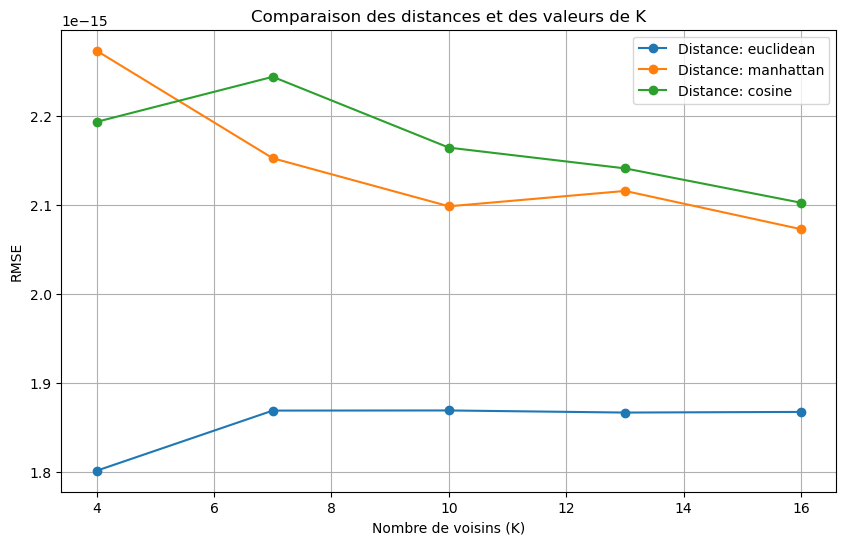

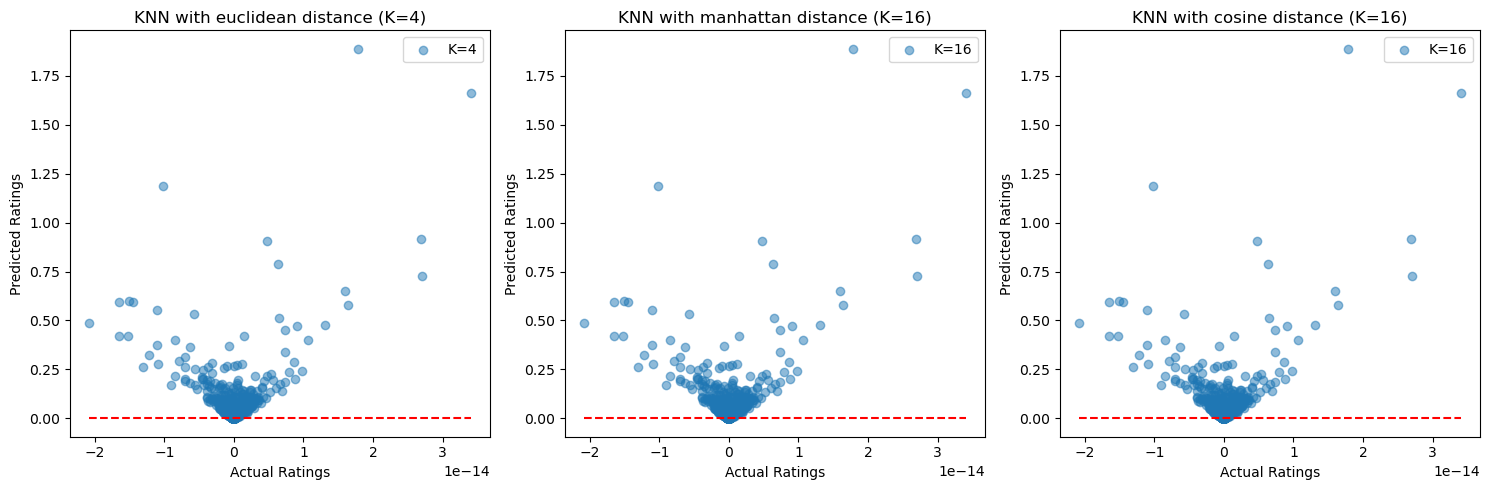

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np




X_train, X_test, y_train, y_test = train_test_split(ratings_normalized, ratings_normalized.mean(axis=1), test_size=0.2, random_state=42)



# Liste des distances et des valeurs de K à tester
metrics = ['euclidean', 'manhattan', 'cosine']
k_values = range(4, 19, 3)

# Stocker les résultats pour chaque combinaison (distance, K)
results = {}


for metric in metrics:
    results[metric] = {}  # Initialiser le dictionnaire pour chaque distance (une seule fois)
    for k in k_values:
        print(f"\nEvaluating KNN with {metric} distance and {k} neighbors")
        
        # Étape 2 : Instancier le modèle KNN
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)

        # Prédire les notes sur le jeu de test
        predictions = knn.predict(X_test)
        
        # Étape 5 : Rajouter la moyenne des utilisateurs
        predictions_with_mean = predictions + user_means.loc[X_test.index].values
        y_test_with_mean = y_test + user_means.loc[X_test.index].values
        
        # Étape 6 : Calculer MSE, RMSE et MAE
        mse = mean_squared_error(y_test_with_mean, predictions_with_mean)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_with_mean, predictions_with_mean)
        
        # Stocker les résultats
        results[metric][k] = {  # Utiliser results[metric][k] au lieu de results[k][k]
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae, 
            'Actual Ratings': y_test.values, 
            'Predicted Ratings': predictions_with_mean
        }

        # Afficher les résultats
        print(f"Distance: {metric}, K: {k}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


# Visualisation des résultats (RMSE uniquement pour l'exemple)
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(k_values, [results[metric][k]['RMSE'] for k in k_values], marker='o', label=f"Distance: {metric}")

plt.xlabel("Nombre de voisins (K)")
plt.ylabel("RMSE")
plt.title("Comparaison des distances et des valeurs de K")
plt.legend()
plt.grid()
plt.show()

# **Visualisation des prédictions par rapport aux notes réelles**
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics):
    k_best = min(k_values, key=lambda k: results[metric][k]['RMSE'])  # On choisit le meilleur K pour chaque distance
    actual_vals = results[metric][k_best]['Actual Ratings']
    predicted_vals = results[metric][k_best]['Predicted Ratings']

    plt.subplot(1, len(metrics), i + 1)
    plt.scatter(actual_vals, predicted_vals, alpha=0.5, label=f"K={k_best}")
    plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"KNN with {metric} distance (K={k_best})")
    plt.legend()

plt.tight_layout()
plt.show()


Evaluating KNN with euclidean distance and 4 neighbors
                    MSE           MAE        R2     STD Error
euclidean  3.252775e-30  5.003618e-16  0.067906  1.803379e-15

Evaluating KNN with manhattan distance and 4 neighbors
                    MSE           MAE        R2     STD Error
manhattan  5.168902e-30  5.429588e-16 -0.481166  2.273498e-15

Evaluating KNN with cosine distance and 4 neighbors
                 MSE           MAE        R2     STD Error
cosine  4.818216e-30  5.715694e-16 -0.380676  2.195006e-15


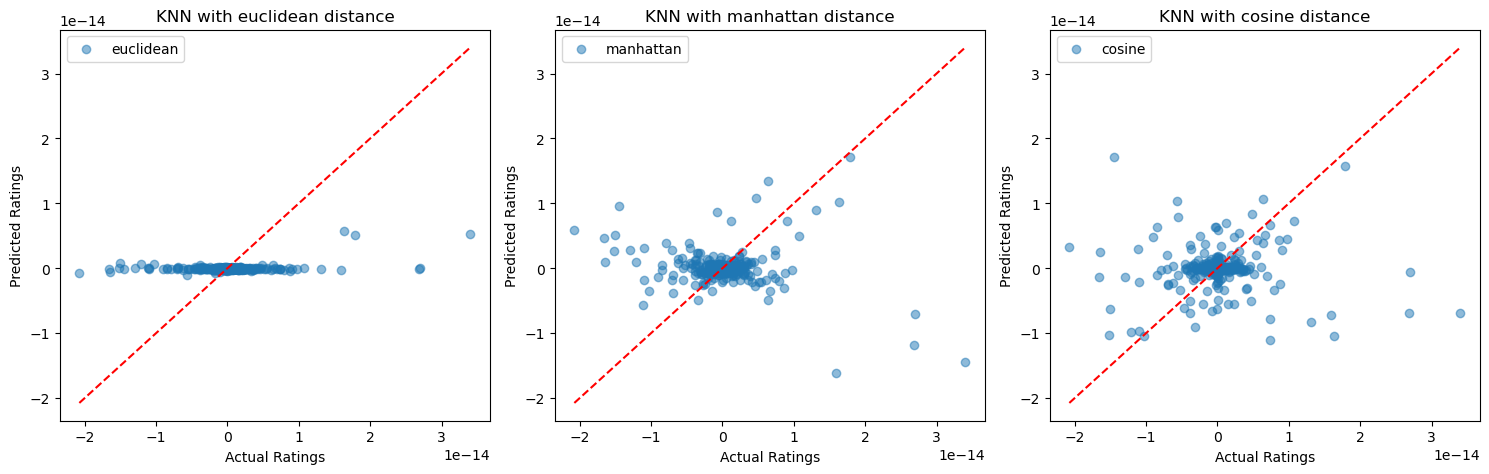


Evaluating KNN with euclidean distance and 7 neighbors
                    MSE           MAE        R2     STD Error
euclidean  3.497369e-30  5.059347e-16 -0.002183  1.870000e-15

Evaluating KNN with manhattan distance and 7 neighbors
                    MSE           MAE        R2     STD Error
manhattan  4.638132e-30  5.296364e-16 -0.329073  2.153504e-15

Evaluating KNN with cosine distance and 7 neighbors
                 MSE           MAE        R2     STD Error
cosine  5.042176e-30  6.134993e-16 -0.444853  2.245309e-15


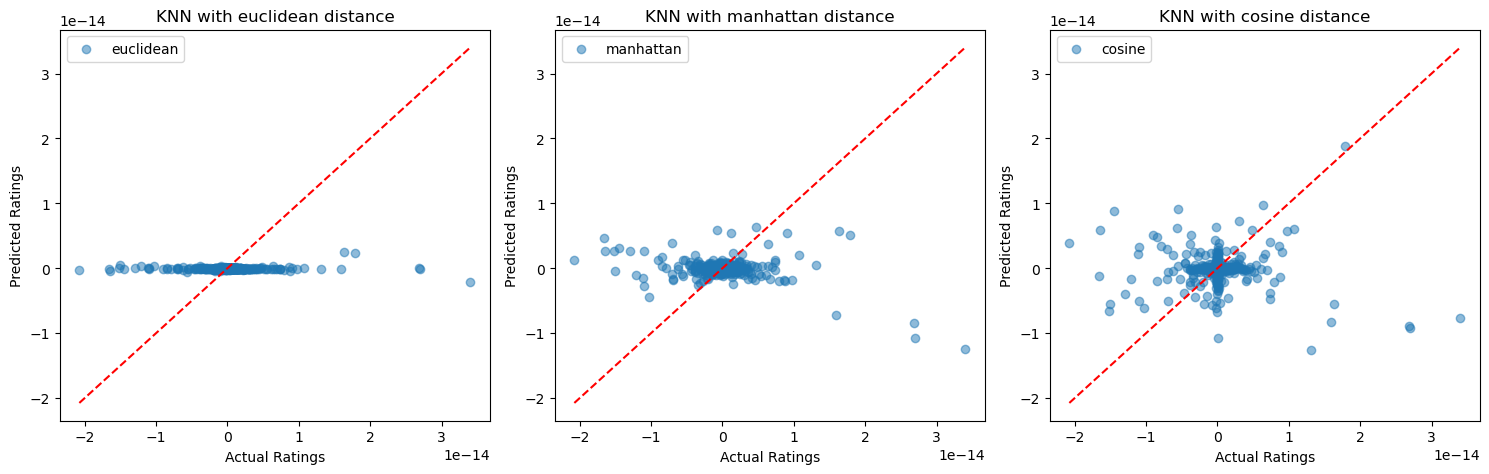


Evaluating KNN with euclidean distance and 10 neighbors
                    MSE           MAE        R2     STD Error
euclidean  3.498488e-30  5.057622e-16 -0.002504  1.870345e-15

Evaluating KNN with manhattan distance and 10 neighbors
                    MSE           MAE        R2     STD Error
manhattan  4.404291e-30  5.288905e-16 -0.262065  2.098519e-15

Evaluating KNN with cosine distance and 10 neighbors
                 MSE           MAE       R2     STD Error
cosine  4.684956e-30  6.665884e-16 -0.34249  2.164353e-15


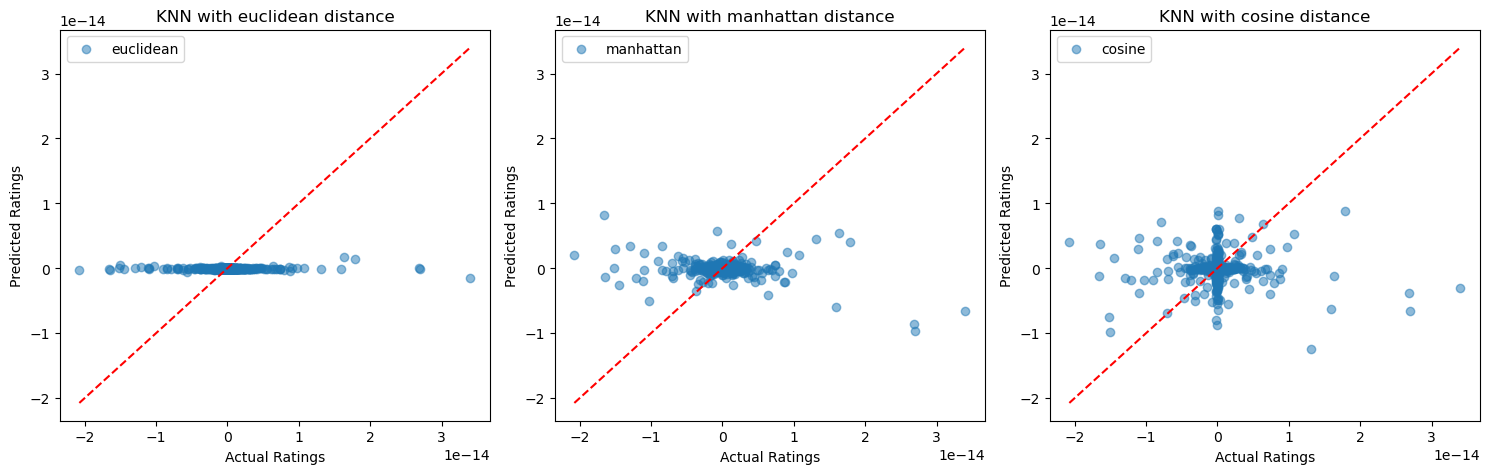


Evaluating KNN with euclidean distance and 13 neighbors
                    MSE           MAE        R2     STD Error
euclidean  3.494799e-30  5.062030e-16 -0.001447  1.869392e-15

Evaluating KNN with manhattan distance and 13 neighbors
                    MSE           MAE        R2     STD Error
manhattan  4.478813e-30  5.306979e-16 -0.283419  2.116189e-15

Evaluating KNN with cosine distance and 13 neighbors
                 MSE           MAE        R2     STD Error
cosine  4.585265e-30  6.822987e-16 -0.313923  2.141309e-15


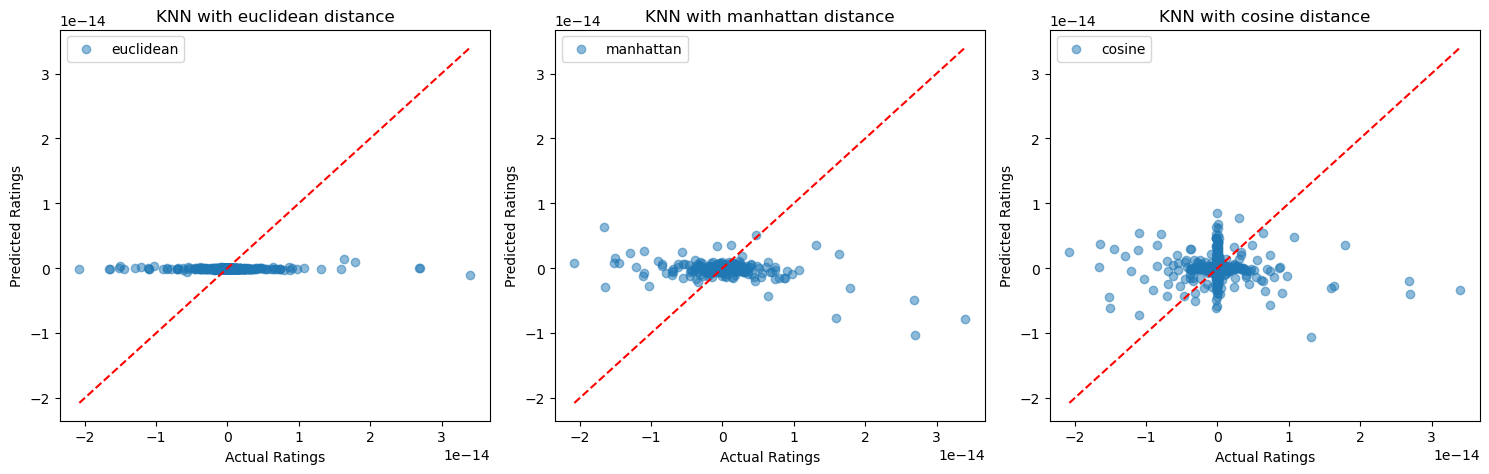


Evaluating KNN with euclidean distance and 16 neighbors
                    MSE           MAE        R2     STD Error
euclidean  3.494456e-30  5.065304e-16 -0.001348  1.869320e-15

Evaluating KNN with manhattan distance and 16 neighbors
                    MSE           MAE        R2     STD Error
manhattan  4.301415e-30  5.251005e-16 -0.232585  2.073908e-15

Evaluating KNN with cosine distance and 16 neighbors
                 MSE           MAE        R2     STD Error
cosine  4.425090e-30  7.075947e-16 -0.268025  2.103508e-15


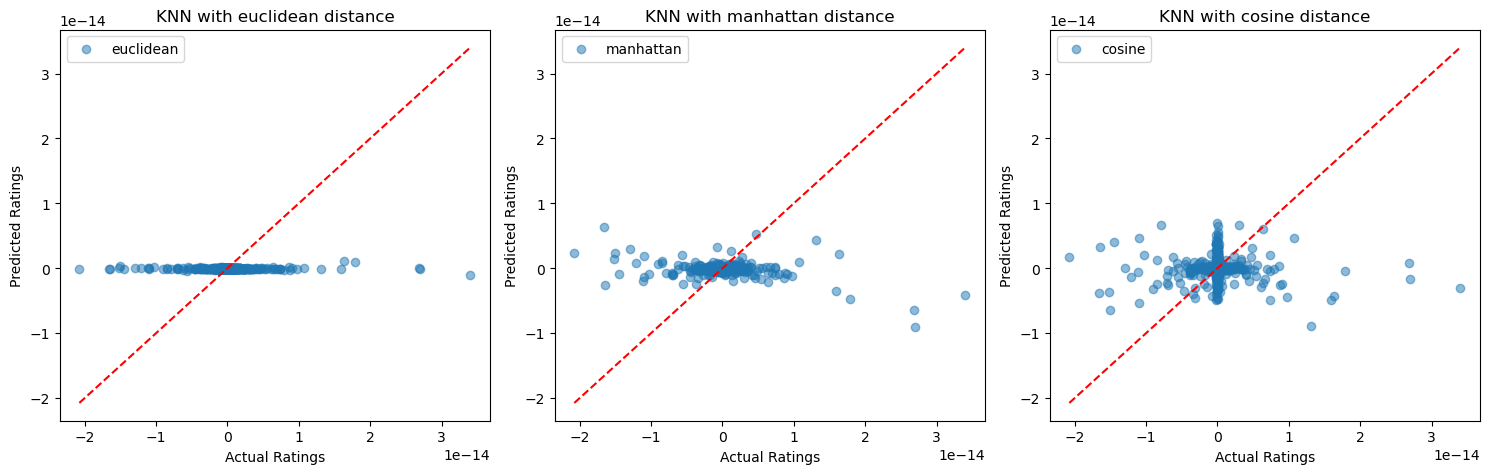

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_knn_with_testsplit(X, metric, n_neighbors=10, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(ratings_normalized, ratings_normalized.mean(axis=1), test_size=0.2, random_state=42)

    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric)

    knn.fit(X_train, y_train)
        
    all_predictions = knn.predict(X_test)


    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, all_predictions)
    r2 = r2_score(y_test, all_predictions)
    mae = mean_absolute_error(y_test, all_predictions)
    std_error = np.std(np.array(y_test) - np.array(all_predictions))

    results = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'STD Error': std_error,
        'Actual Ratings': y_test,
        'Predicted Ratings': all_predictions
    }

    return results

# Test different metrics and store results
metrics = ['euclidean', 'manhattan', 'cosine']
for k in range(4, 19, 3):
    results = {}

    for metric in metrics:
        print(f"\nEvaluating KNN with {metric} distance and {k} neighbors")
        results[metric] = evaluate_knn_with_testsplit(ratings_filled, metric, n_neighbors=k)

        # Print results
        results_df = pd.DataFrame({k: v for k, v in results[metric].items() if k not in ['Actual Ratings', 'Predicted Ratings']}, index=[metric])
        print(results_df)

    # Visualization
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        actual_vals = results[metric]['Actual Ratings']
        predicted_vals = results[metric]['Predicted Ratings']

        plt.subplot(1, len(metrics), i + 1)
        plt.scatter(actual_vals, predicted_vals, alpha=0.5, label=f"{metric}")
        plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title(f"KNN with {metric} distance")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(ratings_subset, ratings_filled.mean(axis=1), test_size=0.2, random_state=42)

# Étape 5 : Modèle KNN (K-Nearest Neighbors)
# On utilise ici une similarité basée sur les distances Euclidiennes pour l'exemple
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

# Entraîner le modèle
knn_model.fit(X_train, y_train)

# Étape 6 : Prédiction et évaluation
predictions = knn_model.predict(X_test)

# Afficher les résultats
print("Prédictions sur les données de test :", predictions)
print("Vraies valeurs :", y_test.values)


In [ ]:
metrics = ['euclidean', 'manhattan', 'cosine']
for k in range(4,19,3):
    results = {}
    fold_results = {}

    for metric in metrics:
        print(f"\nEvaluating KNN with {metric} distance and {k} neighbors")
        results[metric], fold_results[metric] = evaluate_knn_with_kfold(filled_svd, metric, n_neighbors=k)

        # Print fold-wise results
        print(f"\nFold-wise results for {metric}:")
        fold_df = pd.DataFrame(fold_results[metric])
        print(fold_df)

    # Convert average results into a DataFrame
    results_df = pd.DataFrame.from_dict({m: {k: v for k, v in res.items() if k not in ['Actual Ratings', 'Predicted Ratings']}
                                         for m, res in results.items()}, orient='index')

    print("\nAverage KNN Evaluation Results:")
    print(results_df)

    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        actual_vals = results[metric]['Actual Ratings']
        predicted_vals = results[metric]['Predicted Ratings']

        plt.subplot(1, len(metrics), i+1)
        plt.scatter(actual_vals, predicted_vals, alpha=0.5, label=f"{metric}")
        plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title(f"KNN with {metric} distance")
        plt.legend()

    plt.tight_layout()
    plt.show()

In [39]:
from sklearn.neighbors import NearestNeighbors

#Instancier le modèle KNN avec une distance donnée (ex: cosine)
knn = NearestNeighbors(metric='cosine', n_neighbors=5)

#Ajuster le modèle sur la matrice recentrée
knn.fit(ratings_centered)

NearestNeighbors(metric='cosine')

In [ ]:
from sklearn.decomposition import TruncatedSVD

def svd_impute(matrix, n_components=50):
    svd = TruncatedSVD(n_components=n_components)
    matrix_filled = matrix.fillna(matrix.mean())
    matrix_reduced = svd.fit_transform(matrix_filled)
    matrix_reconstructed = svd.inverse_transform(matrix_reduced)

    imputed_df = pd.DataFrame(
        matrix_reconstructed,
        index=matrix.index,
        columns=matrix.columns
    )

    # Keep original values, only fill NaNs
    mask = ~matrix.isna()
    imputed_df[mask] = matrix[mask]

    return imputed_df.clip(0, 10)  # Ensure values stay in valid range


def user_item_mean_impute(matrix):
    # Calculate user and item means
    user_means = matrix.mean(axis=1)
    item_means = matrix.mean()
    global_mean = matrix.mean().mean()

    # Fill NaNs with user-adjusted item means
    filled_matrix = matrix.copy()
    for user in matrix.index:
        user_bias = user_means[user] - global_mean
        for item in matrix.columns:
            if pd.isna(matrix.at[user, item]):
                predicted_rating = item_means[item] + user_bias
                filled_matrix.at[user, item] = np.clip(predicted_rating, 0, 10)

    return filled_matrix

In [ ]:
filled_svd = svd_impute(ratings_matrix_cleaned)
filled_user_item = user_item_mean_impute(ratings_matrix_cleaned)

In [ ]:
# Calculate statistics for each method
methods = {
    'SVD': filled_svd,
    'User-Item Mean': filled_user_item,
}

for name, matrix in methods.items():
    print(f"\n{name} Statistics:")
    print(f"Mean: {matrix.mean().mean():.2f}")
    print(f"Std: {matrix.std().std():.2f}")
    print(f"Distribution of values:")
    print(pd.qcut(matrix.values.flatten(), q=5).value_counts())

#Svd better distrubution, lower mean and lower std -> better stability of data and not overly optimistic,the quantilles are more uniform, the mean has more values at 10


SVD Statistics:
Mean: 7.52
Std: 0.06
Distribution of values:
(-0.001, 6.961]    79954
(6.961, 7.402]     79952
(7.402, 7.861]     79953
(7.861, 8.236]     79953
(8.236, 10.0]      79953
dtype: int64

User-Item Mean Statistics:
Mean: 7.75
Std: 0.10
Distribution of values:
(-0.001, 6.373]    80042
(6.373, 7.59]      79866
(7.59, 8.378]      79994
(8.378, 9.478]     79912
(9.478, 10.0]      79951
dtype: int64


In [ ]:
filled_svd

,ARENA - Roma II,Ave Caesar,Awale - Astérix,Babel,Ballon Cup,Bang!,BattleLore Seconde Édition,Belote,Blokus to go,Bohnanza,...,War of the ring : Anniversary Release,Yams / Yahtzee,Ys,Yspahan,Zombicide : Prison Outbreak,Zombies,Zombies!!!,Zou,Échecs,ごきぶりポーカー
*FitzChevalerie*,7.912287,7.198064,7.260361,7.401695,7.813613,7.014765,8.126653,7.248891,7.958776,7.834389,...,8.349924,6.027201,8.260091,8.459298,8.335524,6.849587,6.183601,6.926992,7.389445,7.030722
0livier,7.727167,7.333867,7.246699,7.344265,7.762732,6.969898,8.007128,7.119783,7.887426,7.789650,...,8.196882,5.997244,6.000000,8.375424,8.317564,6.897596,6.357053,6.884228,7.486215,6.974818
20.100,7.808061,7.442232,7.091946,6.000000,8.173949,6.587459,8.057279,7.326624,7.906535,7.966406,...,8.077278,6.475693,8.545791,8.720011,8.454949,7.095070,6.363330,6.649776,7.292865,7.242089
20cil,7.895334,7.356350,7.444383,7.358074,7.793552,7.092072,7.842773,7.383348,7.860165,7.786226,...,8.114321,6.109020,8.176878,8.400214,7.979404,6.982184,6.086432,6.762469,7.135838,6.915410
3dman,8.008420,7.291745,7.276186,7.370796,7.866277,6.803338,8.008303,7.290492,8.025317,7.870208,...,7.921933,6.092972,8.285510,8.406625,8.309674,4.000000,6.264954,6.890810,7.474174,6.888803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zorglub,7.915895,7.362653,7.440448,7.343511,7.799752,6.953143,10.000000,8.000000,7.981859,7.830261,...,7.982547,6.026742,8.288106,8.323343,8.279626,6.000000,6.305342,6.938221,7.438253,6.868480
zorl,7.828112,7.331496,7.336499,7.456038,7.968425,6.974532,7.939804,7.489430,8.013777,8.125398,...,8.148045,5.979831,8.487943,8.470859,8.211878,6.830597,6.114566,7.047324,7.482239,7.136930
|tigrou|,7.851982,7.253791,7.258980,8.000000,7.844027,6.913853,7.997054,7.222720,7.999191,7.864337,...,8.220959,5.996548,8.246247,8.470233,8.279885,6.861442,6.245306,6.993984,7.492936,7.035368
§Gama§,7.789732,7.227801,7.288653,7.383465,7.825045,7.134843,7.928844,7.294819,8.093046,7.919464,...,8.319338,5.945701,8.052211,8.453438,8.336795,6.871827,6.225030,6.923919,7.327890,6.912131



Evaluating KNN with euclidean distance and 4 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.145907  0.130010  0.860317   0.381973
1     2  0.160724  0.139656  0.850139   0.400833
2     3  0.135514  0.123047  0.869251   0.368122
3     4  0.145819  0.130292  0.861539   0.381858
4     5  0.142553  0.127201  0.864173   0.377561

Evaluating KNN with manhattan distance and 4 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.151596  0.130359  0.854870   0.389340
1     2  0.166240  0.139721  0.844996   0.407621
2     3  0.141204  0.123428  0.863761   0.375767
3     4  0.151009  0.130379  0.856611   0.388599
4     5  0.147416  0.126974  0.859540   0.383934

Evaluating KNN with cosine distance and 4 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.146974  0.130452  0.859296   0.383367
1     2  0.161337  0.139954  0.849568   0.401594
2

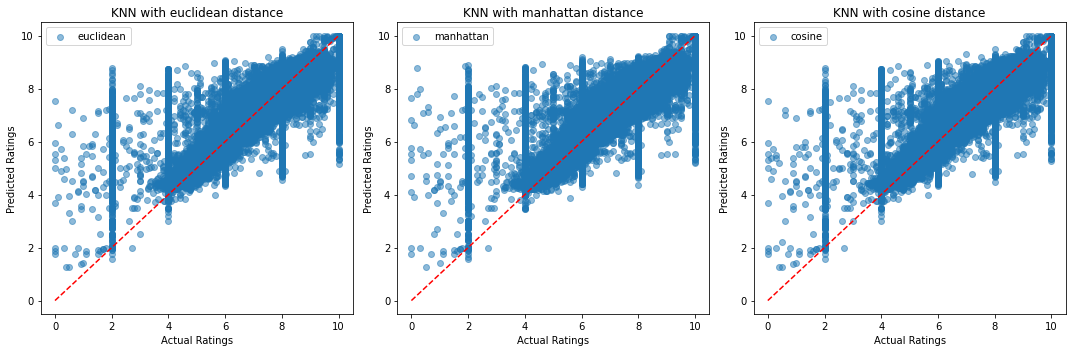


Evaluating KNN with euclidean distance and 7 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.149302  0.133283  0.857066   0.386388
1     2  0.165163  0.143572  0.846000   0.406316
2     3  0.139269  0.126965  0.865628   0.373184
3     4  0.150005  0.134272  0.857565   0.387304
4     5  0.146394  0.130468  0.860514   0.382609

Evaluating KNN with manhattan distance and 7 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.155393  0.134411  0.851236   0.394180
1     2  0.171495  0.144568  0.840096   0.413993
2     3  0.144952  0.127581  0.860145   0.380719
3     4  0.155096  0.134898  0.852730   0.393822
4     5  0.152815  0.131254  0.854396   0.390896

Evaluating KNN with cosine distance and 7 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.150284  0.133726  0.856126   0.387655
1     2  0.165592  0.143685  0.845600   0.406829
2

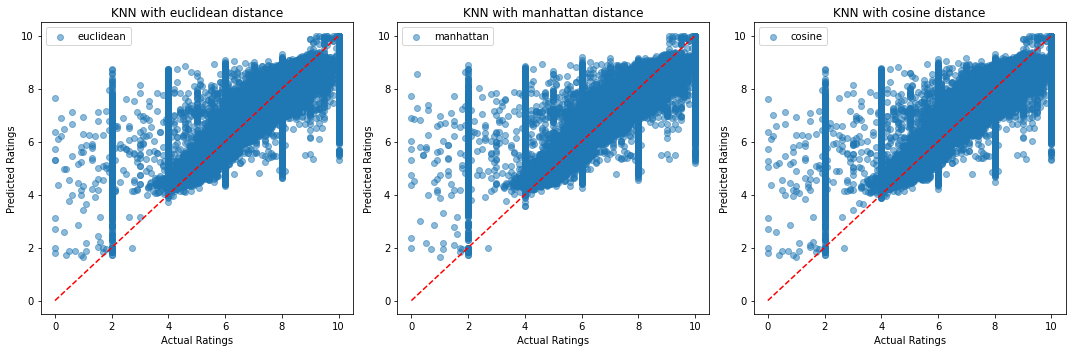


Evaluating KNN with euclidean distance and 10 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.153264  0.136550  0.853273   0.391478
1     2  0.169545  0.147091  0.841915   0.411648
2     3  0.142277  0.129981  0.862725   0.377193
3     4  0.153749  0.137605  0.854010   0.392108
4     5  0.150091  0.133385  0.856991   0.387406

Evaluating KNN with manhattan distance and 10 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.160004  0.137962  0.846821   0.399981
1     2  0.176161  0.148447  0.835746   0.419577
2     3  0.148219  0.131107  0.856993   0.384985
3     4  0.158886  0.138663  0.849132   0.398605
4     5  0.157203  0.134952  0.850215   0.396466

Evaluating KNN with cosine distance and 10 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.154029  0.136883  0.852541   0.392453
1     2  0.170233  0.147456  0.841273   0.41247

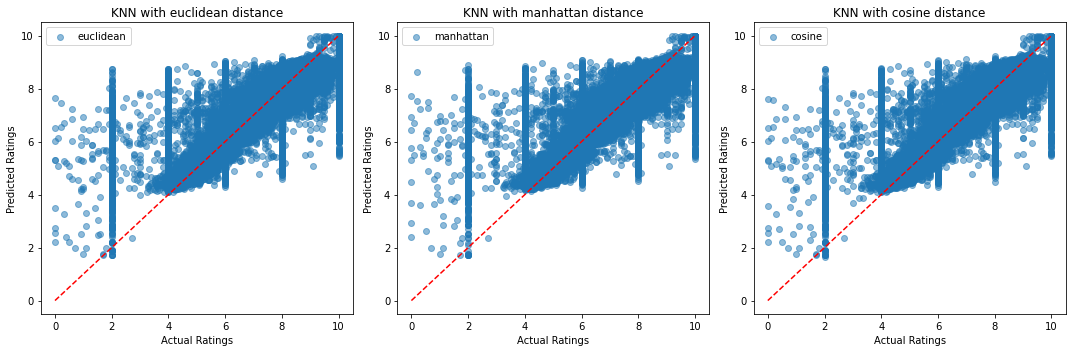


Evaluating KNN with euclidean distance and 13 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.157145  0.139462  0.849558   0.396401
1     2  0.173406  0.150020  0.838314   0.416310
2     3  0.145881  0.133008  0.859248   0.381941
3     4  0.157519  0.140802  0.850430   0.396887
4     5  0.153922  0.136189  0.853341   0.392316

Evaluating KNN with manhattan distance and 13 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.164006  0.141198  0.842990   0.404951
1     2  0.180643  0.151701  0.831567   0.424880
2     3  0.151824  0.134553  0.853515   0.389639
3     4  0.162602  0.141901  0.845603   0.403239
4     5  0.161284  0.138400  0.846326   0.401578

Evaluating KNN with cosine distance and 13 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.158008  0.139897  0.848732   0.397485
1     2  0.174283  0.150447  0.837497   0.41734

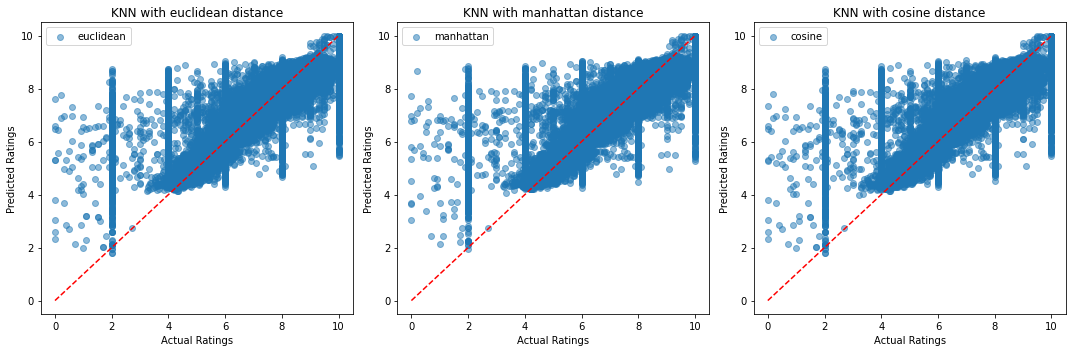


Evaluating KNN with euclidean distance and 16 neighbors

Fold-wise results for euclidean:
   Fold       MSE       MAE        R2  STD Error
0     1  0.160608  0.142277  0.846243   0.400745
1     2  0.177595  0.152985  0.834409   0.421307
2     3  0.149299  0.135973  0.855950   0.386390
3     4  0.160709  0.143624  0.847401   0.400885
4     5  0.157713  0.139230  0.849728   0.397118

Evaluating KNN with manhattan distance and 16 neighbors

Fold-wise results for manhattan:
   Fold       MSE       MAE        R2  STD Error
0     1  0.167397  0.144069  0.839743   0.409118
1     2  0.184400  0.154667  0.828064   0.429276
2     3  0.155102  0.137656  0.850352   0.393824
3     4  0.166522  0.145055  0.841881   0.408070
4     5  0.165056  0.141451  0.842732   0.406249

Evaluating KNN with cosine distance and 16 neighbors

Fold-wise results for cosine:
   Fold       MSE       MAE        R2  STD Error
0     1  0.161769  0.142700  0.845131   0.402187
1     2  0.178092  0.153334  0.833945   0.42187

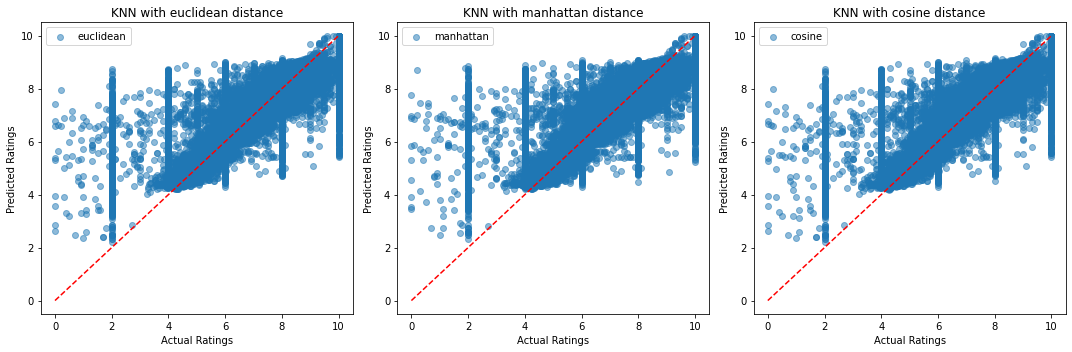

In [ ]:


def evaluate_knn_with_kfold(X, metric, n_neighbors=10, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []
    all_predictions = []
    all_actual = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]

        knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric)

        fold_predictions = []
        fold_actual = []

        for idx in range(len(X_test)):
            user_ratings = X_test.iloc[idx]
            known = user_ratings.notna()

            if known.sum() > 0:
                X_train_filtered = X_train.loc[:, known]
                knn.fit(X_train_filtered, X_train_filtered.values)
                pred = knn.predict(X_test.loc[[X_test.index[idx]], known])

                fold_predictions.extend(pred.flatten())
                fold_actual.extend(user_ratings[known])

        mse = mean_squared_error(fold_actual, fold_predictions)
        r2 = r2_score(fold_actual, fold_predictions)
        mae = mean_absolute_error(fold_actual, fold_predictions)
        std_error = np.std(np.array(fold_actual) - np.array(fold_predictions))

        fold_results.append({
            'Fold': fold + 1,
            'MSE': mse, # The average squared difference between actual and predicted values.
            'MAE': mae, # The average absolute difference between actual and predicted values.
            'R2': r2, # A measure of how well the model explains variance in the data.
            'STD Error': std_error #The standard deviation of the residuals (prediction errors).
        })

        all_predictions.extend(fold_predictions)
        all_actual.extend(fold_actual)

    # Calculate average metrics across folds
    avg_metrics = {
        'MSE': np.mean([r['MSE'] for r in fold_results]),
        'MAE': np.mean([r['MAE'] for r in fold_results]),
        'R2': np.mean([r['R2'] for r in fold_results]),
        'STD Error': np.mean([r['STD Error'] for r in fold_results]),
        'Actual Ratings': all_actual,
        'Predicted Ratings': all_predictions
    }

    return avg_metrics, fold_results

# Test different metrics and store results
metrics = ['euclidean', 'manhattan', 'cosine']
for k in range(4,19,3):
    results = {}
    fold_results = {}

    for metric in metrics:
        print(f"\nEvaluating KNN with {metric} distance and {k} neighbors")
        results[metric], fold_results[metric] = evaluate_knn_with_kfold(filled_svd, metric, n_neighbors=k)

        # Print fold-wise results
        print(f"\nFold-wise results for {metric}:")
        fold_df = pd.DataFrame(fold_results[metric])
        print(fold_df)

    # Convert average results into a DataFrame
    results_df = pd.DataFrame.from_dict({m: {k: v for k, v in res.items() if k not in ['Actual Ratings', 'Predicted Ratings']}
                                         for m, res in results.items()}, orient='index')

    print("\nAverage KNN Evaluation Results:")
    print(results_df)

    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics):
        actual_vals = results[metric]['Actual Ratings']
        predicted_vals = results[metric]['Predicted Ratings']

        plt.subplot(1, len(metrics), i+1)
        plt.scatter(actual_vals, predicted_vals, alpha=0.5, label=f"{metric}")
        plt.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
        plt.xlabel("Actual Ratings")
        plt.ylabel("Predicted Ratings")
        plt.title(f"KNN with {metric} distance")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Conclusion de la 1er semaine

## Les donnés

- We found many inconsistenties in the data (the nombre of non reviewed games between datasets
- we found 2 spam reviews
- No correlation between the number of reviews and rating
- Also no correlation between length of the review with the rating given
- There is a notable skew in the ratings distribution, with most ratings clustering around 7-8
- The data needs more cleaning

## Diffucltés

- The number of review are really low in comparison to the number of user*games without any cleaning we have 196814241 missing values with a fill rate of 0.08% which caused us big computional problems which meant that we spent a long time trying to fill the nun values.
- So we decided to take a very small portions of our data to be able to test knn. (games with more then 120 ratings and users who rated these games)
- With a fill rate so low we tried three different techniques to fill the values, first we tried to do a normal distrubition on each person while taking into consideration which category the game was in and if the person has other ratings in the same categories but this method appeared to be heavy on runtime and diffuclt to well implement as when tested on a small test dataset we found that due to the nature of how people rate (so most ratings are around 7) the disturbution was very centered around 7 and didnt capture well low ratings.
- So we decided to try a mean method where we took the mean of both the mean of the column(game) and the mean of lines (user), this showed  way better results but we also want to try with Singular value decomposition (svd) so we can see if we can use the patterns in the data to create better results.
- The statistics of svd fitted more with what we are trying to do so we choose it

## KNN

- with different folds, different number of neighbor, with different error metrics we discoverd multiple things:
    - First of the  manhatan distance had the worst results out of the 3, both euclidiene and cosine had very similar and better errors
    - while the error seems low, while looking at the graph and the std error we can see a big problem when it predicts wrong, it predicts them very wrong( predicting ratings that are less then 2 as high as 8 !!!!
    - Between the number of neighbor their wasnt any big difference in the results and also with different fold (although to be noted the 3rd fold was the best and the 2nd the worst).
    - The model seem to overly optimistic with its prediction.

Not necce